<a href="https://colab.research.google.com/github/ericbonelli/Cientista-de-Dados_EBAC/blob/main/Tarefa_2_Regress%C3%A3o_Log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf

In [32]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url,
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


In [34]:
# quantidade de nuneros diferentes por variavel
df.nunique()

,0
age,41
sex,2
cp,4
trestbps,50
chol,152
fbs,2
restecg,3
thalach,91
exang,2
oldpeak,40


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada.
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [35]:
def calcular_bivariada(df, var_resposta, var_explicativa):

    # Criar a tabela bivariada
    bivariada = df.groupby(var_explicativa, observed=True).agg(
        Número_de_doentes=(var_resposta, 'sum'),
        Total=(var_resposta, 'count')
    )

    # Criar a tabela bivariada
    bivariada = df.groupby(var_explicativa)[var_resposta].agg(['sum', 'count'])
    bivariada.columns = ['Número de doentes', 'Total']
    bivariada['Número de saudáveis'] = bivariada['Total'] - bivariada['Número de doentes']
    bivariada['Quantidade média de doentes'] = bivariada['Número de doentes'] / bivariada['Total']
    bivariada['Odds'] = bivariada['Número de doentes'] / bivariada['Número de saudáveis']

    # Calcular o Odds Ratio com o total como referência
    total_odds = df[var_resposta].sum() / (df.shape[0] - df[var_resposta].sum())
    bivariada['Odds Ratio'] = bivariada['Odds'] / total_odds

    # Calcular Logito (LOG(Odds))
    bivariada['Logito'] = np.log(bivariada['Odds'])

    # Calcular Weight of Evidence (WOE)
    bivariada['WOE'] = np.log(bivariada['Odds Ratio'])

    return bivariada

In [36]:
# Definir variáveis qualitativas para análise
variaveis_qualitativas = ['sex', 'exang', 'fbs']

# Criar bivariadas para as variáveis selecionadas
bivariadas = {var: calcular_bivariada(df, 'flag_doente', var) for var in variaveis_qualitativas}

# Avaliar qual variável discrimina mais o risco
woe_max = {var: tabela['WOE'].abs().max() for var, tabela in bivariadas.items()}
var_mais_discriminante = max(woe_max, key=woe_max.get)
print(f"\nA variável que mais discrimina o risco é: {var_mais_discriminante}")


A variável que mais discrimina o risco é: exang


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [37]:
def calcular_bivariada_continua(df, var_resposta, var_explicativa, num_categorias=5):

    df = df.dropna(subset=[var_explicativa])

    # Categorizar a variável contínua em grupos
    df[var_explicativa + '_group'] = pd.qcut(
        df[var_explicativa],
        q=num_categorias,
        labels=[f'grupo {i}' for i in range(1, num_categorias + 1)],
    )

    # Criar a tabela bivariada
    bivariada = df.groupby(var_explicativa + '_group',observed=True).agg(
        Número_de_doentes=(var_resposta, 'sum'),
        Total=(var_resposta, 'count'),
        Média_var_explicativa=(var_explicativa, 'mean')
    )
    # Calcular o número de saudáveis
    bivariada['Número_de_saudáveis'] = bivariada['Total'] - bivariada['Número_de_doentes']

    # Calcular as demais estatísticas
    bivariada['Quantidade média de doentes'] = bivariada['Número_de_doentes'] / bivariada['Total']

    # Evitar divisões por zero e calcular Odds
    bivariada['Odds'] = np.where((bivariada['Número_de_saudáveis'] > 0) & (bivariada['Número_de_doentes'] > 0),
                                 bivariada['Número_de_doentes'] / bivariada['Número_de_saudáveis'],
                                 np.nan)

    # Calcular o Odds Ratio com o total como referência
    total_doentes = df[var_resposta].sum()
    total_saudaveis = df.shape[0] - total_doentes
    total_odds = np.nan if total_saudaveis == 0 else total_doentes / total_saudaveis
    bivariada['Odds Ratio'] = np.where(bivariada['Odds'] > 0, bivariada['Odds'] / total_odds, np.nan)

    # Calcular Logito (LOG(Odds))
    bivariada['Logito'] = np.log(bivariada['Odds'])

    # Calcular Weight of Evidence (WOE)
    bivariada['WOE'] = np.log(bivariada['Odds Ratio'])

    # Arredondar valores para melhor visualização
    bivariada = bivariada.round(4)

    # Reordenar colunas
    bivariada = bivariada[['Número_de_doentes', 'Número_de_saudáveis', 'Total', 'Média_var_explicativa', 'Quantidade média de doentes', 'Odds', 'Odds Ratio', 'Logito', 'WOE']]

    # Renomear a coluna 'age_group'
    bivariada = bivariada.rename(columns={'age_group': 'age_group'})

    return bivariada

In [38]:
from google.colab import data_table
# Criar bivariada para a variável contínua 'age'
bivariada_age = calcular_bivariada_continua(df, 'flag_doente', 'age')

# Exibir resultado interativo
print("\nBivariada para Age:")
display(data_table.DataTable(bivariada_age))


Bivariada para Age:


,Número_de_doentes,Número_de_saudáveis,Total,Média_var_explicativa,Quantidade média de doentes,Odds,Odds Ratio,Logito,WOE
age_group,,,,,,,,,
grupo 1,16,47,63,41.2222,0.2540,0.3404,0.4017,-1.0776,-0.9122
grupo 2,22,42,64,50.0000,0.3438,0.5238,0.6180,-0.6466,-0.4812
grupo 3,39,32,71,56.2113,0.5493,1.2188,1.4379,0.1978,0.3632
grupo 4,32,13,45,60.3556,0.7111,2.4615,2.9043,0.9008,1.0662
grupo 5,30,30,60,66.5167,0.5000,1.0000,1.1799,0.0000,0.1654


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [39]:
# Criar o modelo de regressão logística usando a sintaxe com fórmula
modelo = smf.logit("flag_doente ~ sex + C(cp) + trestbps + age", data=df).fit()

# Exibir o resumo do modelo
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Sat, 15 Mar 2025   Pseudo R-squ.:                  0.3097
Time:                        19:03:36   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -8.3407      1.621     -5.145      0.000     -11.518      -5.163
C(cp)[T.2.0]    -0.0617

✅ O modelo tem um Pseudo R² de 0.3097, indicando que explica 30.97% da variabilidade da variável resposta.

✅ Variáveis significativas (p < 0.05): cp=4, sex, trestbps, age.

⚠️ As categorias cp=2 e cp=3 não têm efeito significativo, indicando que apenas certos tipos de dor no peito influenciam na presença de doença cardíaca.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [40]:
# predito
df['predito'] = modelo.predict(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.458229
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.944123
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.886566
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.134929
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.027278


In [41]:
# ategorize essa probabilidade em G=5 grupos (Grupo 1, grupo 2...)
df['grupo'] = pd.qcut(df['predito'], q=5, labels=[f'Grupo {i+1}' for i in range(5)])
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito,grupo
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.458229,Grupo 3
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.944123,Grupo 5
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.886566,Grupo 5
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.134929,Grupo 1
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.027278,Grupo 1


In [42]:
# Calcular a probabilidade média predita e a taxa de eventos reais por grupo
calibragem_df = df.groupby("grupo", observed=True).agg(
    Probabilidade_Predita_Média=("predito", "mean"),
    Taxa_Eventos_Observada=("flag_doente", "mean")
).reset_index()
calibragem_df.head()

,grupo,Probabilidade_Predita_Média,Taxa_Eventos_Observada
0,Grupo 1,0.072008,0.080645
1,Grupo 2,0.209626,0.152542
2,Grupo 3,0.435175,0.483871
3,Grupo 4,0.708861,0.762712
4,Grupo 5,0.874819,0.819672


Text(0.5, 0, 'Grupo')

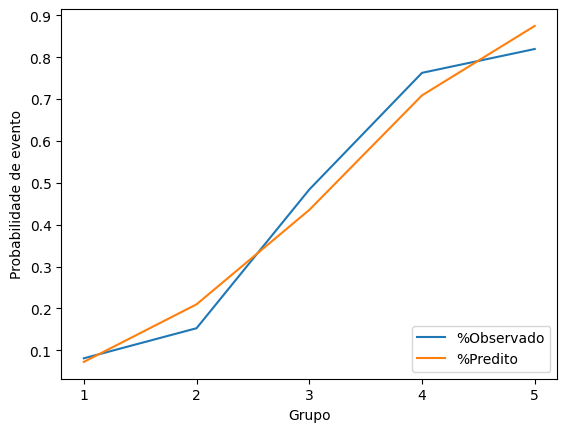

In [43]:
# Plotar o gráfico de calibração
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = calibragem_df['Taxa_Eventos_Observada'].plot(label='%Observado')
ax = calibragem_df['Probabilidade_Predita_Média'].plot(label='%Predito')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

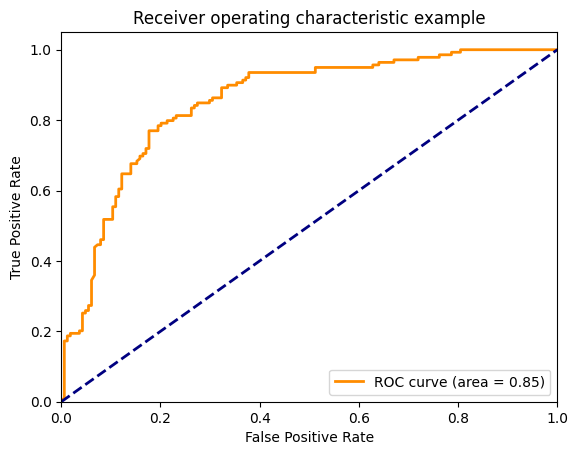

In [44]:
from sklearn.metrics import roc_curve
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])


plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

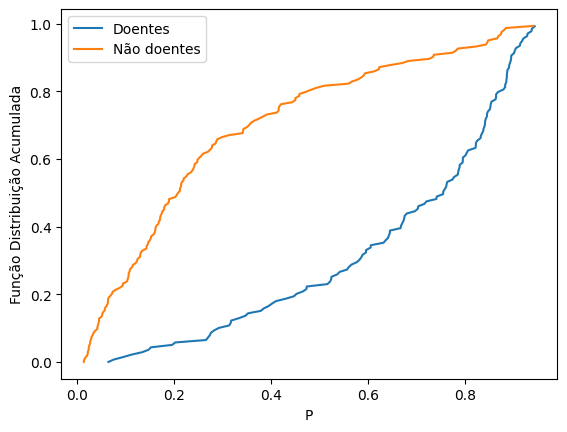

In [45]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df.loc[df['flag_doente']==1,'predito']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Doentes')

score_pop2 = df.loc[df['flag_doente']!=1,'predito']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Não doentes')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')

In [46]:
from sklearn import metrics
from scipy.stats import ks_2samp

acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)

#Gini
gini = 2*auc_ -1

#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 79.54%
KS: 59.30% 
AUC: 85.19% 
GINI: 70.39%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

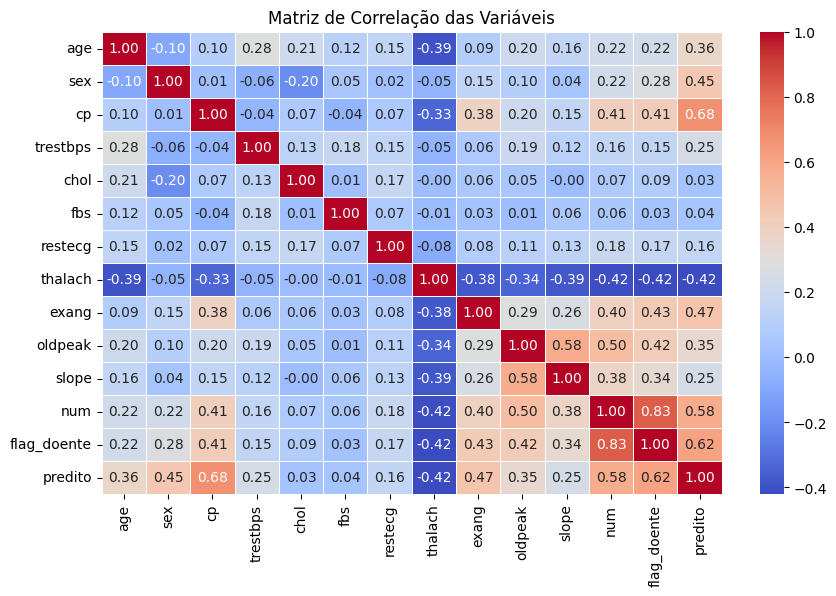

In [47]:
# Criar a matriz de correlação
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação das Variáveis")
plt.show()

Optimization terminated successfully.
         Current function value: 0.412454
         Iterations 7


Text(0.5, 0, 'Grupo')

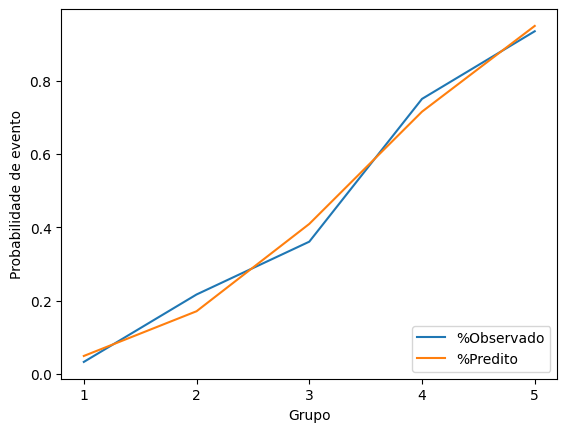

In [50]:
# Criar um novo modelo melhorado
modelo_melhorado = smf.logit("flag_doente ~ sex + C(cp) + thalach + exang + oldpeak + slope + age", data=df).fit()

# Calcular a nova probabilidade predita
df["predito_melhorado"] = modelo_melhorado.predict(df)

# Criar 5 grupos baseados na nova probabilidade predita
df["grupo_melhorado"] = pd.qcut(df["predito_melhorado"], q=5, labels=[f"Grupo {i+1}" for i in range(1, 6)])


# Calcular a nova probabilidade média predita e a taxa de eventos reais por grupo
calibragem_melhorado_df = df.groupby("grupo_melhorado", observed=True).agg(
    Probabilidade_Predita_Média=("predito_melhorado", "mean"),
    Taxa_Eventos_Observada=("flag_doente", "mean")
).reset_index()


# Plotar o gráfico de calibração
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = calibragem_melhorado_df['Taxa_Eventos_Observada'].plot(label='%Observado')
ax = calibragem_melhorado_df['Probabilidade_Predita_Média'].plot(label='%Predito')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

In [55]:
acc_melhorado = metrics.accuracy_score(df['flag_doente'], df['predito_melhorado']>.5)
print(f'Acurácia: {acc_melhorado * 100:.2f}%')

# AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito_melhorado'])
auc_melhorado = metrics.auc(fpr, tpr)

# Gini
gini_melhorado = 2 * auc_melhorado - 1

# KS
ks_stat_melhorado, ks_p_valor_melhorado = ks_2samp(
    df[df["flag_doente"] == 1]["predito_melhorado"],
    df[df["flag_doente"] == 0]["predito_melhorado"]
)

print(f'KS: {ks_stat_melhorado * 100:.2f}% \nAUC: {auc_melhorado * 100:.2f}% \nGINI: {gini_melhorado * 100:.2f}%')

Acurácia: 81.85%
KS: 66.38% 
AUC: 89.10% 
GINI: 78.21%


## Comparação de Métricas entre Modelos

A tabela abaixo apresenta a comparação entre o modelo original e o modelo melhorado, destacando as melhorias em desempenho e poder de discriminação.

| **Métrica**       | **Modelo Original** | **Modelo Melhorado** | **Melhoria** |
|------------------|----------------|------------------|----------|
| **Acurácia**     | 79.54%          | **81.85%**       | ✅ +2.31% |
| **AUC**          | 0.8519          | **0.8910**       | ✅ Melhorou |
| **GINI**         | 0.7039          | **0.7820**       | ✅ Melhorou |
| **KS Estatística** | 0.5929        | **0.6638**       | ✅ Melhorou |

---

## **Melhorias Implementadas no Modelo**

Para melhorar o desempenho do modelo, realizamos as seguintes alterações:

### **Inclusão de novas variáveis relevantes:**
- `thalach` (frequência cardíaca máxima)
- `exang` (angina induzida por exercício)
- `oldpeak` (depressão do segmento ST)
- `slope` (inclinação do segmento ST)
---

## **Conclusões**

✅ **Maior Acurácia:** O modelo agora classifica melhor os pacientes, com **81.85% de acerto**.

✅ **Melhoria na Discriminação:** O **AUC aumentou para 0.8910**, indicando um modelo mais robusto.

✅ **KS Estatística Elevado:** O KS de **0.6638** reforça que o modelo distingue melhor os pacientes doentes dos saudáveis.

✅ **Calibração Aprimorada:** A probabilidade predita está mais alinhada com a taxa observada de eventos.
